In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
import math
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from sklearn.model_selection import KFold

In [2]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
yAll=yAll/25.0

In [3]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')

In [4]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [5]:
# Calculate wind speed 
ws = ((v10Data.v10.values**2)+(u10Data.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [6]:
#Calculate inv
inv=t2mData.t2m.values-tuv850Data.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [7]:
#u shear calculation
ushear=(tuv850Data.u.values-u10Data.u10.values)/(z850Data.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [8]:
t2m=t2mData.t2m.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=w700Data.w.shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)


In [9]:
y=yAll.sel(time=slice('1980-1-1','2014-12-31'))

In [10]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll=ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll=inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll=ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll=w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [11]:
# create mask
oro = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100))
oro.values = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100)).values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values

In [12]:
t2mTsAll.values=t2mTsAll.values*mask
wsTsAll.values=wsTsAll.values*mask
rhTsAll.values=rhTsAll.values*mask
invTsAll.values=invTsAll.values*mask
ushearTsAll.values=ushearTsAll.values*mask
wTsAll.values=wTsAll.values*mask

In [17]:
t2mTsAll.values=xr.where(np.isnan(t2mTsAll.values),  0.000000000001,t2mTsAll.values)
wsTsAll.values=xr.where(np.isnan(wsTsAll.values),  0.000000000001,wsTsAll.values)
rhTsAll.values=xr.where(np.isnan(rhTsAll.values),  0.000000000001,rhTsAll.values)
invTsAll.values=xr.where(np.isnan(invTsAll.values),  0.000000000001,invTsAll.values)
ushearTsAll.values=xr.where(np.isnan(ushearTsAll.values),  0.000000000001,ushearTsAll.values)
wTsAll.values=xr.where(np.isnan(wTsAll.values),  0.000000000001,wTsAll.values)


In [18]:
t2mTsAll.values

array([[[ 1.0000000e-12,  1.0000000e-12,  1.0000000e-12, ...,
          1.0000000e-12,  1.0000000e-12,  1.0000000e-12],
        [ 1.0000000e-12,  1.0000000e-12,  1.0000000e-12, ...,
          1.0000000e-12,  1.0000000e-12,  1.0000000e-12],
        [-1.8211092e+00,  1.0000000e-12,  1.0000000e-12, ...,
          1.0000000e-12,  1.0000000e-12,  1.0000000e-12],
        ...,
        [-3.6464822e-01, -1.0990983e+00, -1.4428333e+00, ...,
          3.2482228e-01, -6.1438596e-01,  6.1371423e-02],
        [-4.1917843e-01, -1.1018363e+00, -1.4446881e+00, ...,
          5.7650310e-01,  5.3092289e-01,  1.9651254e-01],
        [ 2.2880560e-01, -5.5878900e-02, -1.7612962e-01, ...,
         -2.5275985e-02,  1.0787562e-01, -6.2014496e-01]],

       [[ 1.0000000e-12,  1.0000000e-12,  1.0000000e-12, ...,
          1.0000000e-12,  1.0000000e-12,  1.0000000e-12],
        [ 1.0000000e-12,  1.0000000e-12,  1.0000000e-12, ...,
          1.0000000e-12,  1.0000000e-12,  1.0000000e-12],
        [-1.5066510e+00, 

In [19]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()

t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()


In [20]:
t2mTsAll

<xarray.DataArray 't2m' (time: 2418, latitude: 18, longitude: 26)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-1.8211092 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.36464822, -1.0990983 , -1.4428333 , ...,  0.32482228,
         -0.61438596,  0.06137144],
        [-0.4191784 , -1.1018363 , -1.4446881 , ...,  0.5765031 ,
          0.5309229 ,  0.19651252],
        [ 0.2288056 , -0.0558789 , -0.17612962, ..., -0.02527598,
          0.10787562, -0.62014496]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-1.506651  ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.03073826,  0.19600926,  1.0267735 , ...,  0.34641656,
          0.41448703,  2.2293987 ],
        [ 0.23910733,  0.4269938 ,  0.46173236, ..., -0.38937482,
          0.41269365,  0.8876406 ],
        [ 0.5561622 ,  0.80324155,  0.5764211 , ...,  0.17356822,
          0.64599144,  0.06785315]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.16106327,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.3140776 ,  0.5735001 ,  1.1686326 , ...,  0.2410242 ,
          1.1344855 ,  2.5993168 ],
        [-0.15301389,  0.31361008,  0.6322652 , ...,  0.3705295 ,
          0.31862512,  2.1394181 ],
        [ 0.16656528,  0.44127807,  0.7284847 , ..., -0.04225104,
          0.3675832 ,  0.89771473]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T09:00:00 ... 2018-12-31T09:00:00
  * longitude  (longitude) float32 50.0 52.0 54.0 56.0 ... 94.0 96.0 98.0 100.0
  * latitude   (latitude) float32 34.0 32.0 30.0 28.0 26.0 ... 6.0 4.0 2.0 0.0
Attributes:
    long_name:  2 metre temperature
    units:      K

In [21]:
t2mTs=t2mTsAll.sel(time=slice('1980-1-1','2014-12-31'))
wsTs=wsTsAll.sel(time=slice('1980-1-1','2014-12-31'))
rhTs=rhTsAll.sel(time=slice('1980-1-1','2014-12-31'))
invTs=invTsAll.sel(time=slice('1980-1-1','2014-12-31'))
wTs=wTsAll.sel(time=slice('1980-1-1','2014-12-31'))
ushearTs=ushearTsAll.sel(time=slice('1980-1-1','2014-12-31'))


In [22]:
t2m_train,t2m_test,ws_train,ws_test,rh_train,rh_test,inv_train,inv_test, w_train, w_test,ushear_train, ushear_test,y_train,y_test= train_test_split( t2mTs,wsTs,rhTs,invTs, wTs,ushearTs,y,test_size=0.20, random_state=0)

In [23]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape


wstrain=ws_train.values
wstrain=wstrain[:,:,:,None]
wstrain.shape

rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape


invtrain=inv_train.values
invtrain=invtrain[:,:,:,None]
invtrain.shape

wtrain=w_train.values
wtrain=wtrain[:,:,:,None]
wtrain.shape

usheartrain=ushear_train.values
usheartrain=usheartrain[:,:,:,None]
usheartrain.shape


(1736, 18, 26, 1)

In [24]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape


wstest=ws_test.values
wstest=wstest[:,:,:,None]
wstest.shape

rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape


invtest=inv_test.values
invtest=invtest[:,:,:,None]
invtest.shape

wtest=w_test.values
wtest=wtest[:,:,:,None]
wtest.shape

usheartest=ushear_test.values
usheartest=usheartest[:,:,:,None]
usheartest.shape


(434, 18, 26, 1)

In [25]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(434, 1)

In [82]:
#X_test=np.array([t2mtest,rhtest,wstest,invtest,wtest,usheartest])
X_test=np.array([rhtest,wstest,invtest,wtest,usheartest])
X_test.shape

#X_train=np.array([t2mtrain,rhtrain,wstrain,invtrain,wtrain,usheartrain])
X_train=np.array([rhtrain,wstrain,invtrain,wtrain,usheartrain])
X_train.shape
X_train

array([[[[[ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          ...,
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00]],

         [[ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          ...,
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00]],

         [[-5.51580012e-01],
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          ...,
          [ 0.00000000e+00],
          [ 0.00000000e+00],
          [ 0.00000000e+00]],

         ...,

         [[ 1.90732729e+00],
          [ 1.40017891e+00],
          [ 1.37705612e+00],
          ...,
          [-2.74114251e+00],
          [ 1.25631845e+00],
          [ 1.27556443e+00]],

         [[ 1.20808041e+00],
          [ 8.38665545e-01],
          [ 1.53037274e+00],
          ...,
          [-5.34125507e-01],
          [-6.69255137e-01],
          [ 2.19014525e+00]],

         [[ 2.80591547e-01],
 

In [83]:
X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape

(434, 5, 18, 26, 1)

Epoch 1/20
55/55 [==============================] - 8s 140ms/step - loss: 0.2564 - accuracy: 0.0506 - val_loss: 0.1698 - val_accuracy: 0.0691
Epoch 2/20
55/55 [==============================] - 8s 138ms/step - loss: 0.1746 - accuracy: 0.0511 - val_loss: 0.1612 - val_accuracy: 0.0691
Epoch 3/20
55/55 [==============================] - 8s 137ms/step - loss: 0.1473 - accuracy: 0.0574 - val_loss: 0.1163 - val_accuracy: 0.0691
Epoch 4/20
55/55 [==============================] - 8s 140ms/step - loss: 0.1157 - accuracy: 0.0494 - val_loss: 0.1079 - val_accuracy: 0.0691
Epoch 5/20
55/55 [==============================] - 7s 136ms/step - loss: 0.1077 - accuracy: 0.0534 - val_loss: 0.0985 - val_accuracy: 0.0691
Epoch 6/20
55/55 [==============================] - 7s 133ms/step - loss: 0.1044 - accuracy: 0.0598 - val_loss: 0.0942 - val_accuracy: 0.0691
Epoch 7/20
55/55 [==============================] - 7s 132ms/step - loss: 0.0966 - accuracy: 0.0548 - val_loss: 0.1005 - val_accuracy: 0.0691
Epoch 

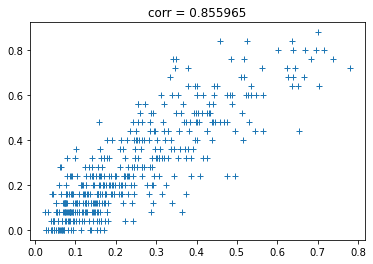

In [84]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)),)
model.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model.add(AveragePooling3D(pool_size=2,padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = model.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=20)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],ytest[:,0])[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')
scores = model.evaluate(X_test_reshape, ytest, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("model Vgg AveragePooling Kernel 32,64 and dropout 0.2 dense 256 lr=0.01") 

In [85]:
t2mTst=t2mTsAll.sel(time=slice('2015-1-1','2018-12-31'))
wsTst=wsTsAll.sel(time=slice('2015-1-1','2018-12-31'))
rhTst=rhTsAll.sel(time=slice('2015-1-1','2018-12-31'))
invTst=invTsAll.sel(time=slice('2015-1-1','2018-12-31'))
wTst=wTsAll.sel(time=slice('2015-1-1','2018-12-31'))
ushearTst=ushearTsAll.sel(time=slice('2015-1-1','2018-12-31'))
yt=yAll.sel(time=slice('2015-1-1','2018-12-31'))

In [86]:
t2m_t=t2mTst.values
t2m_t=t2m_t[:,:,:,None]
t2m_t.shape


ws_t=wsTst.values
ws_t=ws_t[:,:,:,None]
ws_t.shape

rh_t=rhTst.values
rh_t=rh_t[:,:,:,None]
rh_t.shape


inv_t=invTst.values
inv_t=inv_t[:,:,:,None]
inv_t.shape

w_t=wTst.values
w_t=w_t[:,:,:,None]
w_t.shape

ushear_t=ushearTst.values
ushear_t=ushear_t[:,:,:,None]
ushear_t.shape


(248, 18, 26, 1)

In [87]:
#X_t=np.array([t2m_t,rh_t,ws_t,inv_t,w_t,ushear_t])
X_t=np.array([rh_t,ws_t,inv_t,w_t,ushear_t])
X_t.shape


(5, 248, 18, 26, 1)

In [88]:
X_t_reshape = np.einsum('lkija->klija',X_t)
X_t_reshape.shape

(248, 5, 18, 26, 1)

In [89]:
yLRt=model.predict(X_t_reshape)

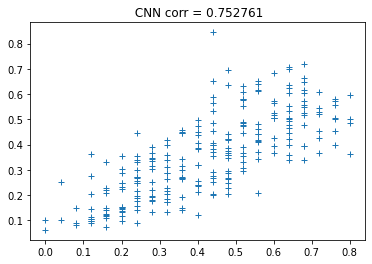

In [90]:
testcorr = np.corrcoef(yLRt[:,0],yt)[0,1]

#acc_svr       = round(regLin.score(Xt, yt) * 100, 2)

#print("Accuracy of base Linear Regression model is ,",(acc_svr/100)**0.5)

plt.title(' CNN corr = %f'%testcorr)

plt.plot(yt,yLRt[:,0],'+')


In [91]:
t2mAll=t2mTs.values
t2mAll=t2mAll[:,:,:,None]
t2mAll.shape


wsAll=wsTs.values
wsAll=wsAll[:,:,:,None]
wsAll.shape

rhAll=rhTs.values
rhAll=rhAll[:,:,:,None]
rhAll.shape


invAll=invTs.values
invAll=invAll[:,:,:,None]
invAll.shape

wAll=wTs.values
wAll=wAll[:,:,:,None]
wAll.shape

ushearAll=ushearTs.values
ushearAll=ushearAll[:,:,:,None]
ushearAll.shape


(2170, 18, 26, 1)

In [92]:
#X_All=np.array([t2mAll,rhAll,wsAll,invAll,wAll,ushearAll])
X_All=np.array([rhAll,wsAll,invAll,wAll,ushearAll])
X_All.shape

X_All_reshape = np.einsum('lkija->klija',X_All)
X_All_reshape.shape

(2170, 5, 18, 26, 1)

In [93]:
yLR=model.predict(X_All_reshape)

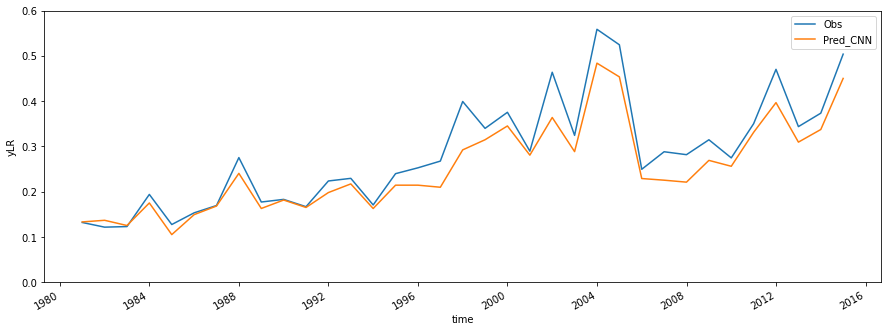

In [94]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR[:,0])}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataCNN_1.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_CNN')
#dump(y,'TS1dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()


In [95]:
ynf=y.where(y<0.040, drop=True)
print(ynf.shape[0])

yint1=y.where(y>=0.04,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
print(yintf.shape[0])

yWd=y.where(y>=0.48, drop=True)
print(yWd.shape[0])

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)
print(yLRnf.yLR.shape[0])

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>=0.04,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)
print(yLRintf.yLR.shape[0])

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>=0.48,drop=True)
print(yLRWd.yLR.shape[0])

print((ynf.shape[0]+yintf.shape[0]+yWd.shape[0]))
print((yLRnf.yLR.shape[0]+yLRintf.yLR.shape[0]+yLRWd.yLR.shape[0]))

123
1569
478
56
1847
267
2170
2170


Text(0.5, 1.0, 'CNN')

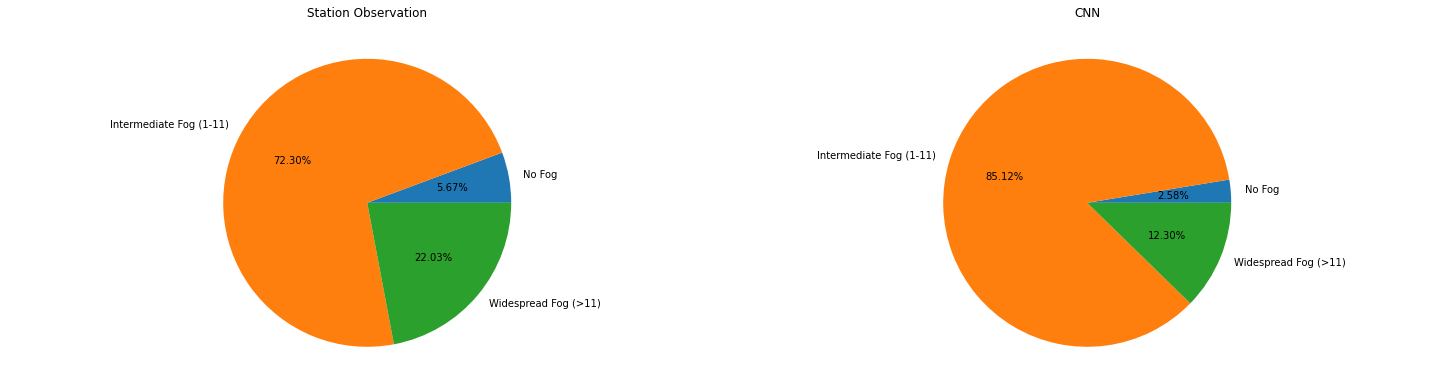

In [96]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')
ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')

In [97]:
pie1dataObs = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
pie1dataLR = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
#dump(pie1dataObs, 'pie1dataObs_1.joblib') 
dump(pie1dataLR,'pie1dataCNN_1.joblib')

['pie1dataCNN_1.joblib']

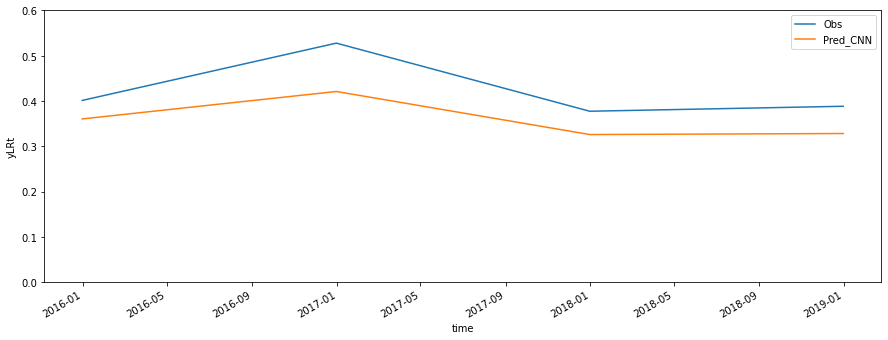

In [98]:
y_predLin_dst=xr.Dataset({'yLRt': (('time'), yLRt[:,0])}, coords={'time': yt.time})
dump(y_predLin_dst.yLRt,'TS2dataCNN_1.joblib')
plt.figure(figsize=[15,5])
yt.resample(time='1Y').mean().plot(label='Obs')
y_predLin_dst.resample(time='1Y').mean().yLRt.plot(label='Pred_CNN')
##dump(yt,'TS2dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()

In [99]:
ynft=yt.where(yt<0.040, drop=True)
print(ynft.shape[0])

yint1t=yt.where(yt>=0.04,drop=True)
yintft=yint1t.where(yint1t<0.48,drop=True)
print(yintft.shape[0])

yWdt=yt.where(yt>=0.48, drop=True)
print(yWdt.shape[0])

print((ynft.shape[0]+yintft.shape[0]+yWdt.shape[0]))

yLRnft=y_predLin_dst.where(y_predLin_dst.yLRt<0.04,drop=True)
print(yLRnft.yLRt.shape[0])

yLRint1t=y_predLin_dst.where(y_predLin_dst.yLRt>=0.04,drop=True)
yLRintft=yLRint1t.where(yLRint1t<0.48,drop=True)
print(yLRintft.yLRt.shape[0])

yLRWdt=y_predLin_dst.where(y_predLin_dst.yLRt>=0.48,drop=True)
print(yLRWdt.yLRt.shape[0])

print((yLRnft.yLRt.shape[0]+yLRintft.yLRt.shape[0]+yLRWdt.yLRt.shape[0]))

2
136
110
248
0
186
62
248


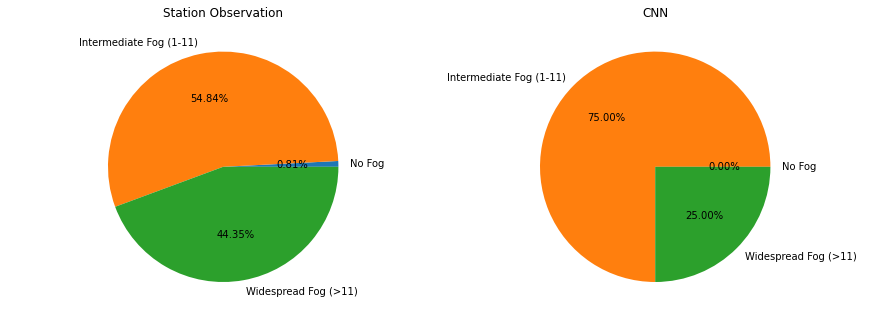

In [100]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN')
plt.show()

In [101]:
pie1dataObs = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
pie1dataLR = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
#dump(pie1dataObs, 'pie2dataObs_1.joblib') 
dump(pie1dataLR,'pie2dataCNN_1.joblib')

['pie2dataCNN_1.joblib']